### Packages

In [1]:
import json
import matplotlib.pyplot as plt

In [2]:
history = %run /bsuhome/tnde/geoscience/albedo_downscaling/functions/unet1_main.py
# history = %run /bsuhome/tnde/geoscience/albedo_downscaling/functions/Albedo-U-Net.py

2025-11-24 17:32:26.491650: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 17:32:26.537124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500

Epoch 1: saving model to /bsuhome/tnde/scratch/felix/UNet/Results_new/training/cp.weights.h5
10/10 - 7s - 691ms/step - loss: 0.0075 - rmse: 0.2540 - val_loss: 0.0029 - val_rmse: 0.1283 - learning_rate: 1.0000e-04
Epoch 2/500

Epoch 2: saving model to /bsuhome/tnde/scratch/felix/UNet/Results_new/training/cp.weights.h5
10/10 - 3s - 267ms/step - loss: 0.0034 - rmse: 0.1939 - val_loss: 0.0022 - val_rmse: 0.1363 - learning_rate: 1.0000e-04
Epoch 3/500

Epoch 3: saving model to /bsuhome/tnde/scratch/felix/UNet/Results_new/training/cp.weights.h5
10/10 - 3s - 263ms/step - loss: 0.0025 - rmse: 0.1890 - val_loss: 0.0015 - val_rmse: 0.1122 - learning_rate: 1.0000e-04
Epoch 4/500

Epoch 4: saving model to /bsuhome/tnde/scratch/felix/UNet/Results_new/training/cp.weights.h5
10/10 - 3s - 324ms/step - loss: 0.0023 - rmse: 0.1793 - val_loss: 0.0015 - val_rmse: 0.1209 - learning_rate: 1.0000e-04
Epoch 5/500

Epoch 5: saving model to /bsuhome/tnde/scratch/felix/UNet/Results_new/training/cp.w

## Plot training and validation loss

In [3]:
TF_HISTORY_PATH = "/bsuhome/tnde/scratch/felix/UNet/Results_new/training/history_new.json"

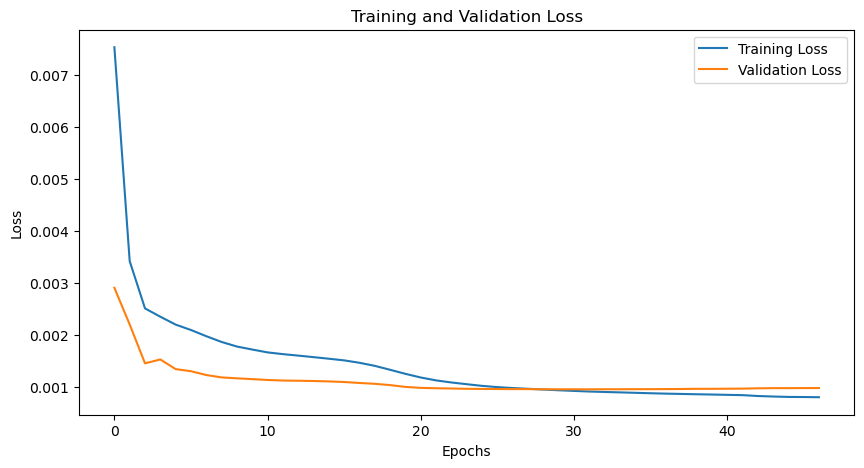

In [4]:
with open(TF_HISTORY_PATH, 'r') as file:
    history_dict = json.load(file)
    
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

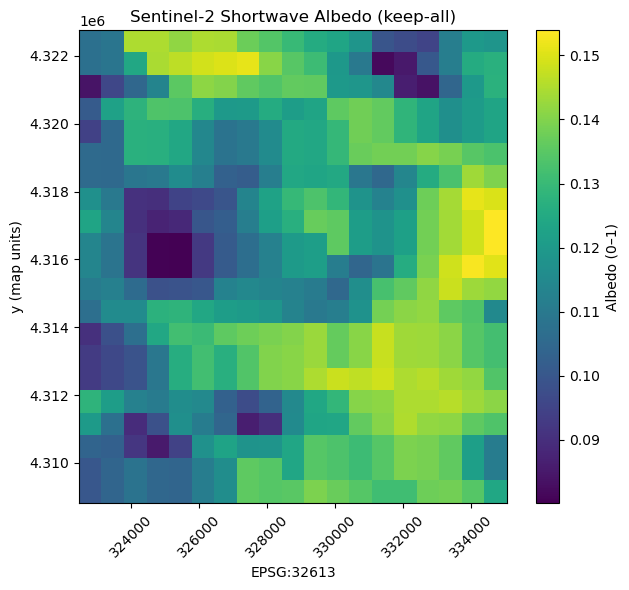

In [5]:
import rasterio as rio
from rasterio.plot import plotting_extent

# tif = "/bsuhome/tnde/scratch/felix/modis/blue_sky_albedo/2021244_modis_blue_sky_albedo_.tif"
# tif = "/bsuhome/tnde/scratch/felix/UNet/Unet_train_preds_modis_new/predicted_2021244_modis_blue_sky_albedo_.tif"
tif = "/bsuhome/tnde/scratch/felix/modis_newest/blue_sky_albedo_sail/2021244_modis_blue_sky_albedo_.tif"
with rio.open(tif) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

plt.figure(figsize=(8,6))
im = plt.imshow(arr, extent=extent, origin="upper")
plt.tick_params(axis='x', rotation=45)
plt.title("Sentinel-2 Shortwave Albedo (keep-all)")
plt.xlabel(ds.crs.to_string()); plt.ylabel("y (map units)")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Albedo (0–1)")
plt.tight_layout(); plt.show()

## Predict training data 

The predictions here will be used as input for downscaling from MODIS to Sentinel-2

In [6]:
# Packages
import os
import sys

# Clip path to all helper functions
function_path = os.path.expanduser("~/geoscience/albedo_downscaling/functions")
sys.path.append(function_path)
# import all the helper functions.
from albedo_unet1_fxns import *

In [9]:
load_model = True
if load_model: #load save model
    model_pred = tf.keras.models.load_model(TF_FELIX_MODEL_UNMASKED_PATH)
else: #load model weights. Works equivalently as loading the save model.
    model_pred = get_UNet_model((24, 24, 1))  # Input shape must match training data
    model_pred.load_weights(TENSORFLOW_CHECKPOINT_PATH)
    
model_pred

<Functional name=functional, built=True>

In [21]:
# Load invalid dates and append hard-coded invalid GOES dates
invalid_dates = convert_dates(INVALID_DATES_PATH)
for date in INVALID_GOES_DATES_BOTH:
    if date not in invalid_dates:
        invalid_dates.append(date)

# training data
# Define training date range
start_date_training_data = datetime(2021, 9, 1)
end_date_training_data   = datetime(2022, 12, 31)

goes_masked = True  # keep as you had

# --- training ---
goes_train_dict, _, goes_train_paths= get_data_and_mask(start_date_training_data, end_date_training_data, 
                                                        goes_date_gate={}, invalid_dates=invalid_dates, 
                                                        is_goes=True, use_masked_goes_dir=goes_masked)

modis_train_dict, modis_train_mask, modis_train_paths = get_data_and_mask(start_date_training_data, end_date_training_data, 
                                                                          goes_date_gate=goes_train_dict, invalid_dates=invalid_dates, 
                                                                          is_goes=False, use_masked_goes_dir=goes_masked)

goes_training_data_4d = stack_array_4d(goes_train_dict)           # (N,H,W,1)
modis_training_data_4d = stack_array_4d(modis_train_dict)         # (N,H,W,1)
modis_training_mask_3d = stack_masks_3d(modis_train_mask)         # (N,H,W)


# validation data
start_date_validation_data = datetime(2022, 9, 2)
end_date_validation_data   = datetime(2022, 12, 31)

# --- validation ---
goes_val_dict, _, goes_val_paths = get_data_and_mask(start_date_validation_data, end_date_validation_data, 
                                                     goes_date_gate={}, invalid_dates=invalid_dates, 
                                                     is_goes=True, use_masked_goes_dir=goes_masked)
modis_val_dict, modis_val_mask, modis_val_paths = get_data_and_mask(start_date_validation_data, end_date_validation_data, 
                                                                    goes_date_gate=goes_val_dict, invalid_dates=invalid_dates, 
                                                                    is_goes=False, use_masked_goes_dir=goes_masked)

goes_validation_data_4d = stack_array_4d(goes_val_dict)
modis_validation_data_4d = stack_array_4d(modis_val_dict)
val_mask_3d = stack_masks_3d(modis_val_mask)


# --- testing (non-overlapping) ---
# start_date_test_data = datetime(2021, 9, 1)
start_date_test_data = datetime(2023, 1, 1)
end_date_test_data   = datetime(2023, 6, 15)

goes_test_dict, _, goes_test_paths = get_data_and_mask(start_date_test_data, end_date_test_data, 
                                                       goes_date_gate={}, invalid_dates=invalid_dates, 
                                                       is_goes=True, use_masked_goes_dir=goes_masked)
modis_test_dict, modis_test_mask, modis_test_paths = get_data_and_mask(start_date_test_data, end_date_test_data, 
                                                                       goes_date_gate=goes_test_dict, invalid_dates=invalid_dates, 
                                                                       is_goes=False, use_masked_goes_dir=goes_masked)
goes_test_data_final  = stack_array_4d(goes_test_dict)
modis_test_data_final = stack_array_4d(modis_test_dict)
test_mask_3d          = stack_masks_3d(modis_test_mask)

In [22]:
# goes_train_paths
len(goes_test_data_final)

88

In [23]:
training = False
if training:
    preds = model_pred.predict(goes_training_data_4d)  # Shape: (N, 24, 24, 1)
else:
    preds = model_pred.predict(goes_test_data_final)  # Shape: (N, 24, 24, 1)
    
# preds

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [24]:
# Convert predictions from (N, 24, 24, 1) to (N, 24, 24), then unpad
preds_unpadded = remove_padding(preds)  # Result: (N, 21, 19, 1) or (N, 21, 19)
# preds_unpadded

In [25]:
if training:
    r2_pred = masked_r2_numpy(modis_training_data_4d[..., 0], preds[..., 0], modis_training_mask_3d)
else:
    r2_pred = masked_r2_numpy(goes_test_data_final[..., 0], preds[..., 0], test_mask_3d)
    
print(f"Masked R-square on training data: {r2_pred:.3f}")
# np.save("/bsuhome/tnde/scratch/felix/UNet/Unet_preds_modis_new/training_predictions_unpadded.npy", preds_unpadded)


Masked R-square on training data: 0.602


## Run once

Uncomment the cell below and run only when needed.

In [26]:
# if training:
#     modis_train_paths_sorted = [modis_train_paths[d] for d in sorted(modis_train_dict)]
#     save_preds_as_geotiff(preds_unpadded, modis_train_paths_sorted, "/bsuhome/tnde/scratch/felix/UNet/Unet_train_preds_modis_new/")
# else:
#     modis_val_paths_sorted = [modis_val_paths[d] for d in sorted(modis_val_dict)]
#     save_preds_as_geotiff(preds_unpadded, modis_val_paths_sorted, "/bsuhome/tnde/scratch/felix/UNet/Unet_train_preds_modis_new/")
    
# # modis_train_paths_sorted

In [27]:
def masked_r2_per_image(y_true, y_pred, mask, eps=1e-12):
    """
    Compute masked r-sqaured per image.
    
    Parameters:
    - y_true, y_pred: shape (N, H, W)
    - mask: shape (N, H, W)
    
    Returns:
    - r2_scores: shape (N,), R² per image
    """
    r2_scores = []
    for i in range(y_true.shape[0]):
        y = y_true[i][mask[i] > 0.5]
        p = y_pred[i][mask[i] > 0.5]
        if len(y) == 0:
            r2_scores.append(np.nan)
            continue
        ss_res = np.sum((y - p) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2) + eps
        r2_scores.append(1.0 - ss_res / ss_tot)
    return np.array(r2_scores)


In [31]:
if training:
    r2_per_image = masked_r2_per_image(
        modis_training_data_4d[..., 0],  # shape (N, H, W)
        preds[..., 0],                  # shape (N, H, W)
        modis_training_mask_3d                    # shape (N, H, W)
    )
else:
    r2_per_image = masked_r2_per_image(
        modis_test_data_final[..., 0],  # shape (N, H, W)
        preds[..., 0],                  # shape (N, H, W)
        test_mask_3d                    # shape (N, H, W)
    )
print("R-sqaured per image:", r2_per_image[r2_per_image>0.5])
print("Mean R-squared:", np.nanmean(r2_per_image[r2_per_image>0.5]))

R-sqaured per image: [0.54819618 0.58496983 0.5331332  0.5392659  0.53535681 0.55656737
 0.54211803 0.53210982 0.52998352 0.50489014 0.53831941 0.53414871]
Mean R-squared: 0.5399215754681915


In [40]:
len(preds)

65

In [36]:
# Use your actual arrays (padded shapes)
if training:
    y_true = modis_training_data_4d[..., 0]      # (N, 24, 24)
    y_pred = preds[..., 0]                       # (N, 24, 24)
    mask   = modis_training_mask_3d              # (N, 24, 24)
else:
    y_true = modis_test_data_final[..., 0]      # (N, 24, 24)
    y_pred = preds[..., 0]                       # (N, 24, 24)
    mask   = test_mask_3d              # (N, 24, 24)    

valid = mask > 0.5

# ----- Global R² (matches masked_r2_numpy) -----
y_all = y_true[valid]
p_all = y_pred[valid]
mu_global = y_all.mean()
ss_res_global = np.sum((y_all - p_all)**2)
ss_tot_global = np.sum((y_all - mu_global)**2)
r2_global = 1.0 - ss_res_global / (ss_tot_global + 1e-12)
print("Global R-squared:", r2_global)

# ----- Per-image R² and weighted average -----
def r2_per_image(y_true, y_pred, mask, eps=1e-12):
    N = y_true.shape[0]
    r2 = np.full(N, np.nan, dtype=np.float32)
    ss_res_i = np.zeros(N, dtype=np.float64)
    ss_tot_i = np.zeros(N, dtype=np.float64)
    for i in range(N):
        v = mask[i] > 0.5
        if not np.any(v):
            continue
        y = y_true[i][v]; p = y_pred[i][v]
        mu_i = y.mean()
        ss_res_i[i] = np.sum((y - p)**2)
        ss_tot_i[i] = np.sum((y - mu_i)**2)
        r2[i] = 1.0 - ss_res_i[i] / (ss_tot_i[i] + eps)
    return r2, ss_res_i, ss_tot_i

r2_img, ss_res_i, ss_tot_i = r2_per_image(y_true, y_pred, mask)
r2_macro = np.nanmean(r2_img)

w = ss_tot_i.copy()
w[~np.isfinite(r2_img)] = 0.0
r2_weighted = np.sum(w * r2_img) / (np.sum(w) + 1e-12)

print("Macro mean R-sqaured    :", r2_macro)
print("SS_tot-weighted R-squared:", r2_weighted)
print("Median per-image R-sqaured:", np.nanmedian(r2_img))

Global R-squared: 0.6204591537926538
Macro mean R-sqaured    : 0.2675781
SS_tot-weighted R-squared: 0.28466061070159737
Median per-image R-sqaured: 0.3181515


In [37]:
def masked_rmse_per_image(y_true, y_pred, mask):
    N = y_true.shape[0]
    rmse = np.full(N, np.nan, dtype=np.float32)
    for i in range(N):
        v = mask[i] > 0.5
        if not np.any(v):
            continue
        e = y_true[i][v] - y_pred[i][v]
        rmse[i] = np.sqrt(np.mean(e**2))
    return rmse

def masked_nrmse_per_image(y_true, y_pred, mask, mode="std", eps=1e-12):
    """mode='std' divides by per-image std(y); mode='range' divides by (max-min)."""
    N = y_true.shape[0]
    nrmse = np.full(N, np.nan, dtype=np.float32)
    for i in range(N):
        v = mask[i] > 0.5
        if not np.any(v):
            continue
        y = y_true[i][v]
        e = y - y_pred[i][v]
        rmse = np.sqrt(np.mean(e**2))
        if mode == "std":
            denom = np.std(y)
        else:  # 'range'
            denom = (np.max(y) - np.min(y))
        if denom < eps:
            continue  # near-constant truth -> nRMSE undefined
        nrmse[i] = rmse / denom
    return nrmse

rmse_per_img  = masked_rmse_per_image(y_true, y_pred, mask)
nrmse_per_img = masked_nrmse_per_image(y_true, y_pred, mask, mode="std")

print("Median per-image RMSE:", np.nanmedian(rmse_per_img))
print("Median per-image nRMSE (std):", np.nanmedian(nrmse_per_img))


Median per-image RMSE: 0.10662514
Median per-image nRMSE (std): 0.8257346
